# Exploratory Data Analysis

In [1]:
from datetime import datetime
import re
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
def rawToDf(file, key):
#     Converts raw .txt file into a Data Frame
    
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    time_form = {
        '12hr' : '%I:%M %p',
        '24hr' : '%H:%M',
        'custom': ''
    }
    date_form = {
        '12hr': '%d/%m/%Y',
        'custom' : ''
    }
    with open(file, 'r', encoding='utf-8') as raw_data:
        # print(raw_data.read())
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        date = [dt.split(',')[0] for dt in date_time]
        time = [dt.split(', ')[1].strip(' -') for dt in date_time]
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg, 'date_sent': date, 'time': time}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    df['date_sent'] =  pd.to_datetime(df['date_sent'], format=date_form[key])
    df['time'] = pd.to_datetime(df['time'], format=time_form[key])
    df['hour'] = pd.to_datetime(df['date_time']).dt.hour
    df['day'] = df['date_sent'].dt.day_name()
    df['month'] = df['date_sent'].dt.month
    
    df['count'] = 1
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("group_notification")
            msgs.append(a[0])
            
    
    # creating new columns         
    df['user'] = usernames
    df['message'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

In [3]:
df = rawToDf('chat.txt', '12hr')

In [4]:
df

,date_time,date_sent,time,hour,day,month,count,user,message
0,2020-01-26 16:19:00,2020-01-26,1900-01-01 16:19:00,16,Sunday,1,1,group_notification,Messages and calls are end-to-end encrypted. N...
1,2020-01-24 20:25:00,2020-01-24,1900-01-01 20:25:00,20,Friday,1,1,group_notification,"Tanay Kamath (TSEC, CS) created group ""CODERS👨..."
2,2020-01-26 16:19:00,2020-01-26,1900-01-01 16:19:00,16,Sunday,1,1,group_notification,You joined using this group's invite link
3,2020-01-26 16:20:00,2020-01-26,1900-01-01 16:20:00,16,Sunday,1,1,group_notification,+91 99871 38558 joined using this group's invi...
4,2020-01-26 16:20:00,2020-01-26,1900-01-01 16:20:00,16,Sunday,1,1,group_notification,+91 91680 38866 joined using this group's invi...
...,...,...,...,...,...,...,...,...,...
13650,2020-10-02 02:05:00,2020-10-02,1900-01-01 02:05:00,2,Friday,10,1,"Darshan Rander (TSEC, IT)",MCQs mark kiya
13651,2020-10-02 02:05:00,2020-10-02,1900-01-01 02:05:00,2,Friday,10,1,"Darshan Rander (TSEC, IT)",Sign-in kiya😂😅
13652,2020-10-02 02:11:00,2020-10-02,1900-01-01 02:11:00,2,Friday,10,1,"Tanay Kamath (TSEC, CS)",Incognito se na?
13653,2020-10-02 02:28:00,2020-10-02,1900-01-01 02:28:00,2,Friday,10,1,"Darshan Rander (TSEC, IT)",Yup


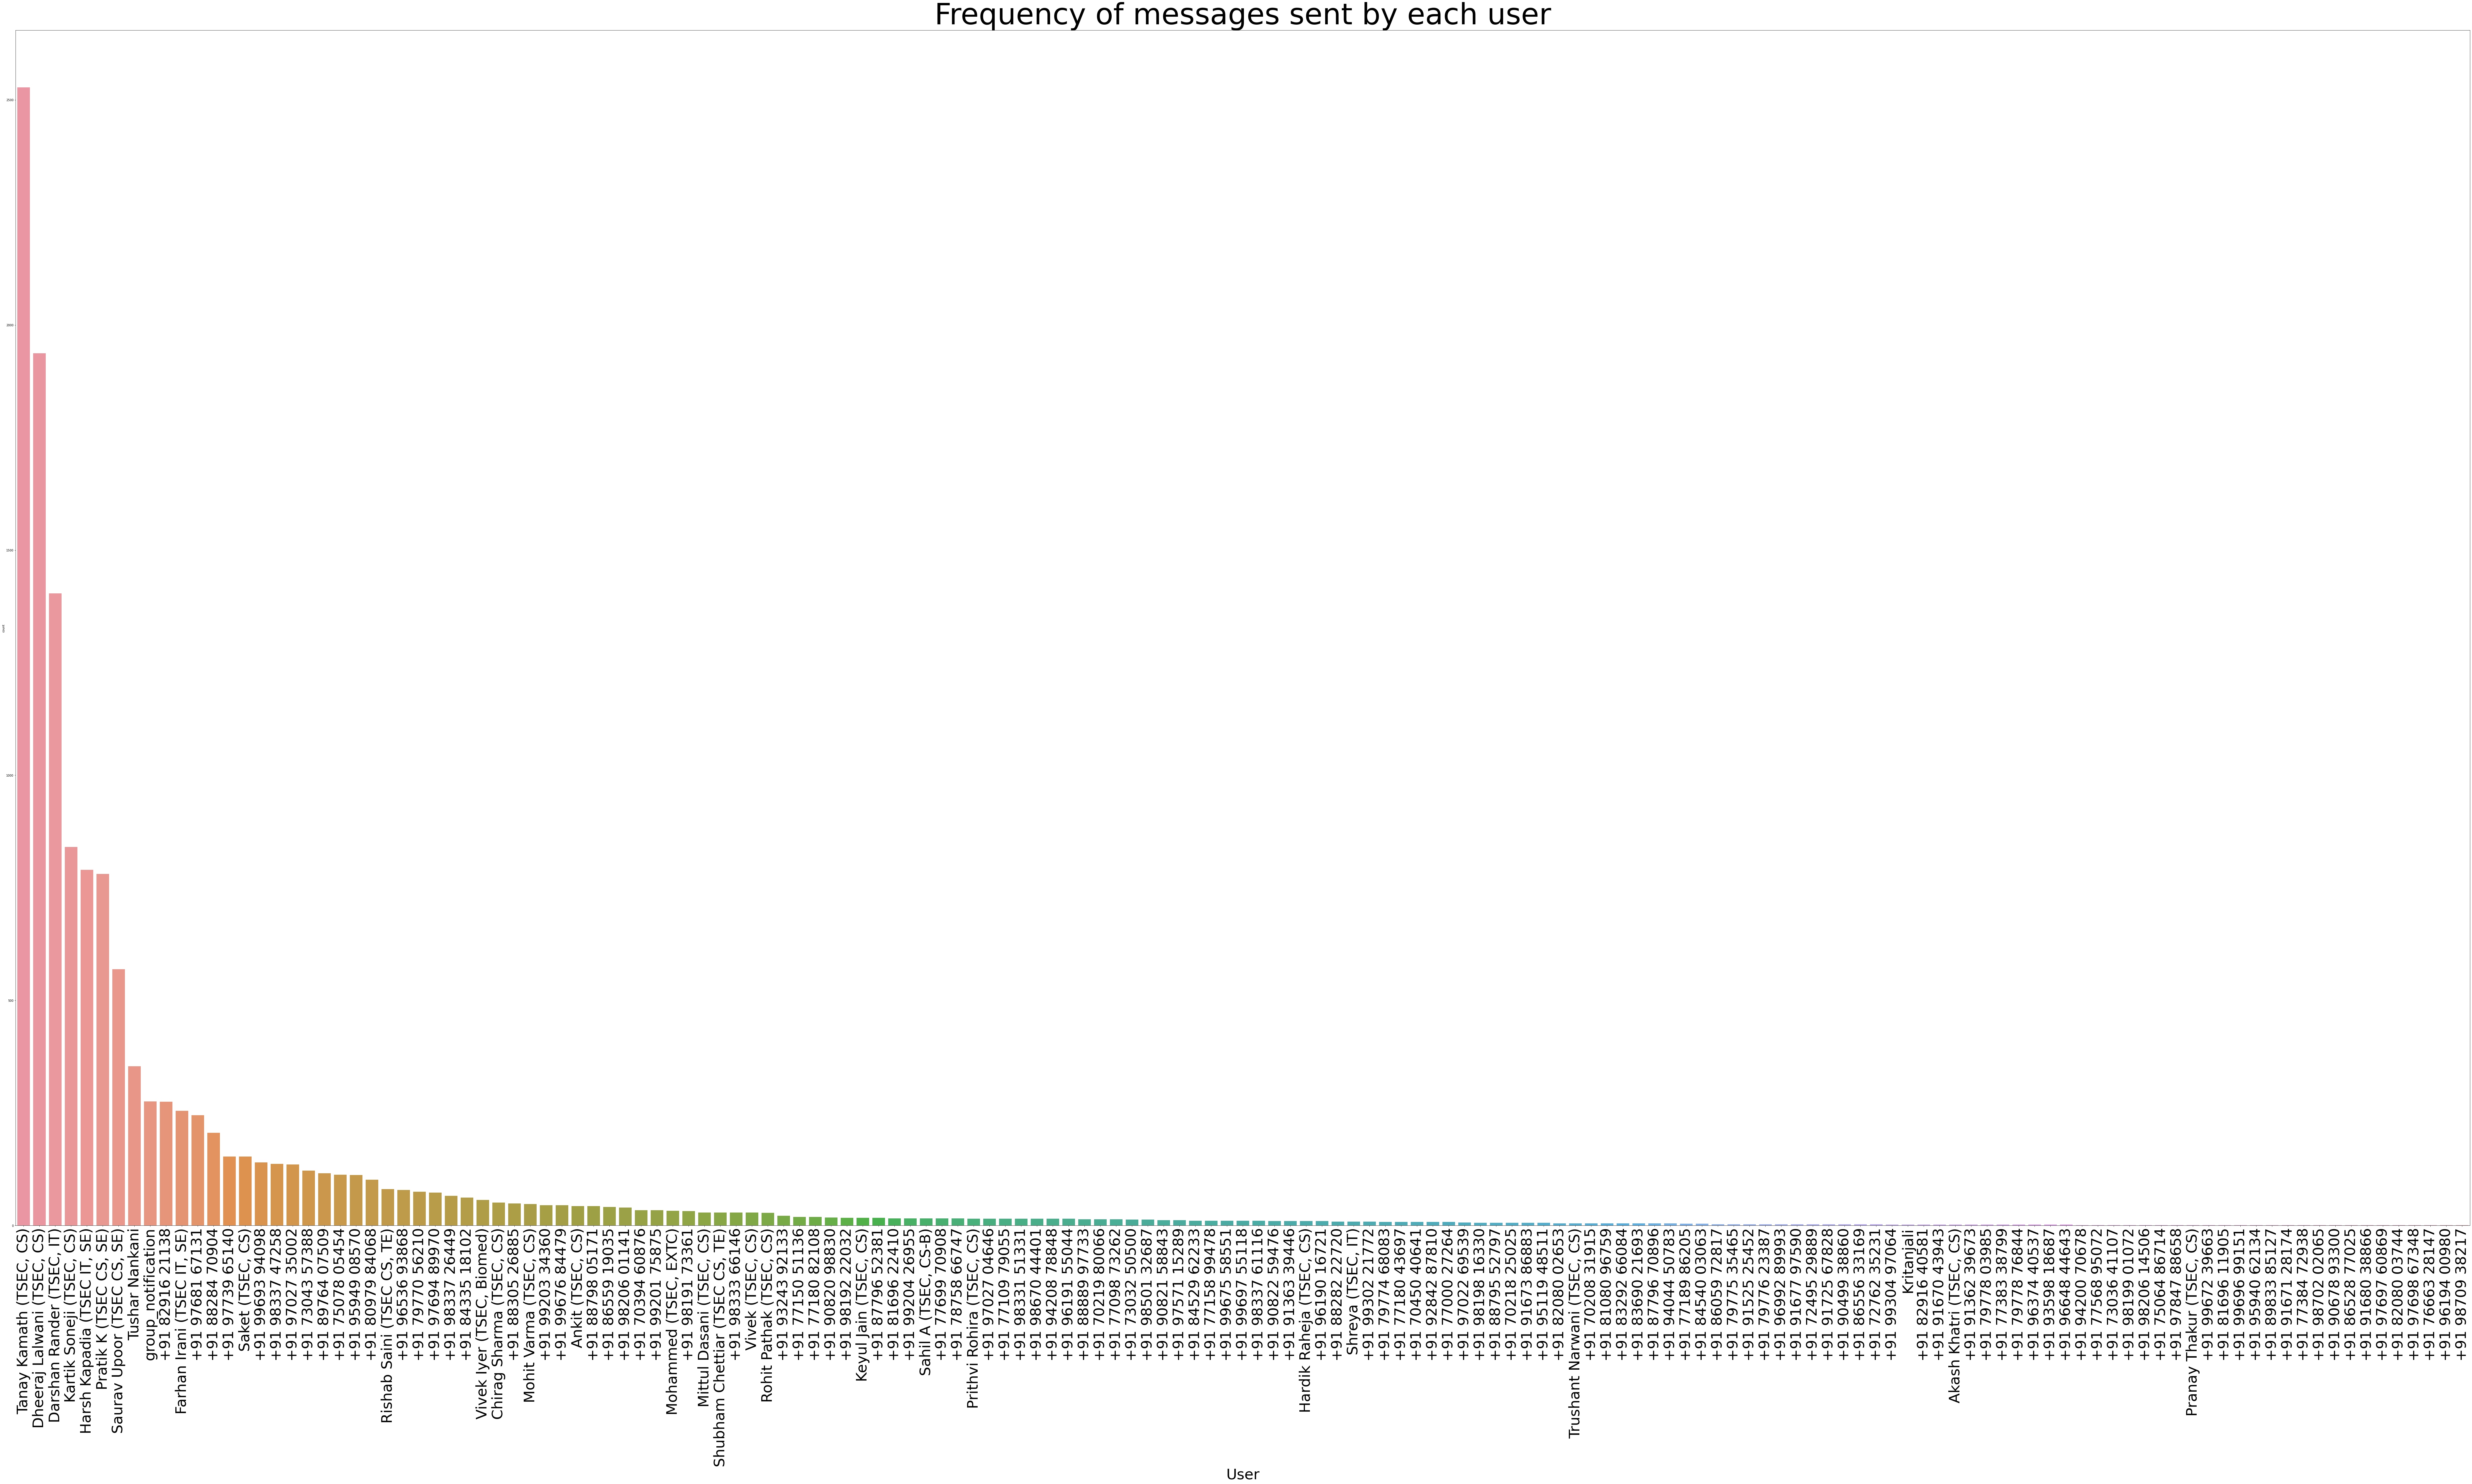

In [5]:
#Total number of messages sent out
fig,axs = plt.subplots(figsize = (150,75))
sns.countplot(x = 'user', data = df, order = df['user'].value_counts().index)
axs.set_title('Frequency of messages sent by each user', fontsize = 100)
axs.set_xticklabels(axs.get_xticklabels(),rotation = 90, fontsize = 50)
axs.set_xlabel('User',fontsize = 50)
fig = axs.get_figure()
fig.savefig('Generated Visuals/Frequency of messages sent by each user.png')

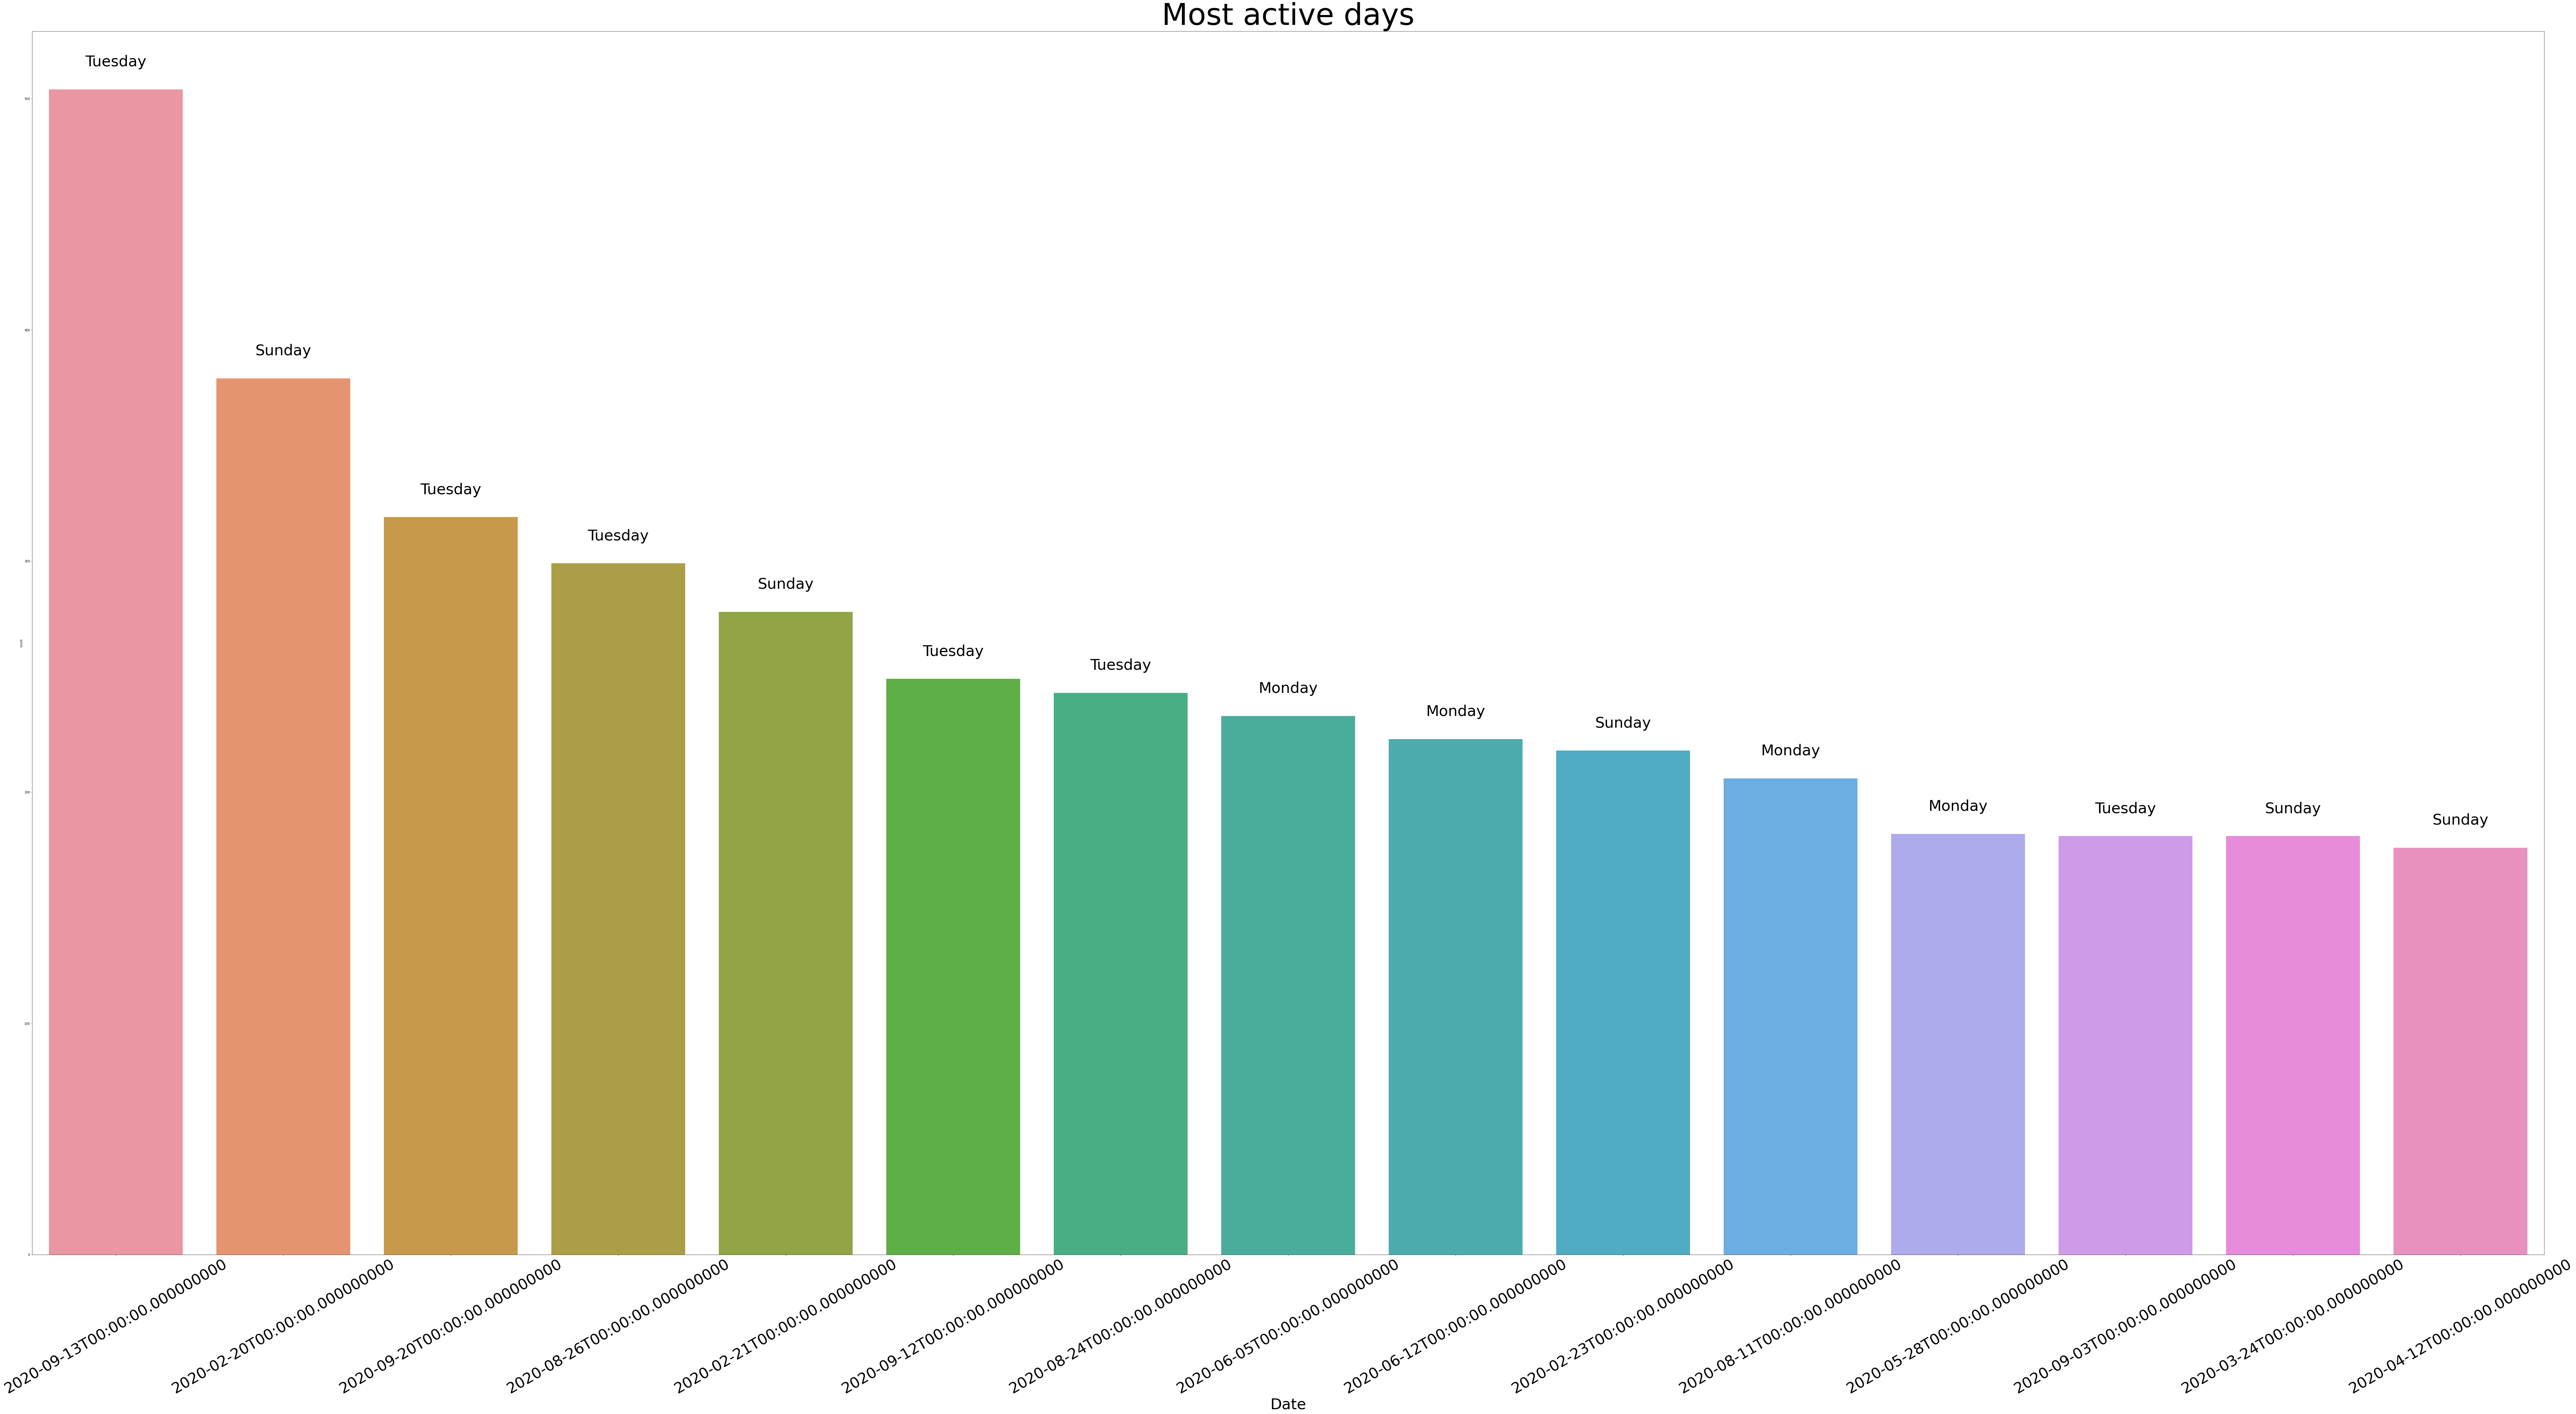

In [6]:
#Most active days
fig,axs = plt.subplots(figsize = (150,75))
grp_by_date = df.groupby('date_sent').sum().reset_index().sort_values(by = 'count',ascending = False).head(15)
grp_by_date['day_sent'] = df['day']
axs = sns.barplot(y = 'count', x = 'date_sent', data = grp_by_date)
for bar, label in zip(axs.patches, grp_by_date['day_sent']):
    x = bar.get_x()
    w = bar.get_width()
    h = bar.get_height()
    axs.text(x + w/2.0, h + 10, label, ha = 'center',fontsize = 50)
axs.set_title("Most active days", fontsize = 100)
axs.set_xticklabels(axs.get_xticklabels(),rotation = 30,fontsize = 50)
axs.set_xlabel("Date",fontsize = 50)
axs.get_figure().savefig("Generated Visuals/Most active days.png")

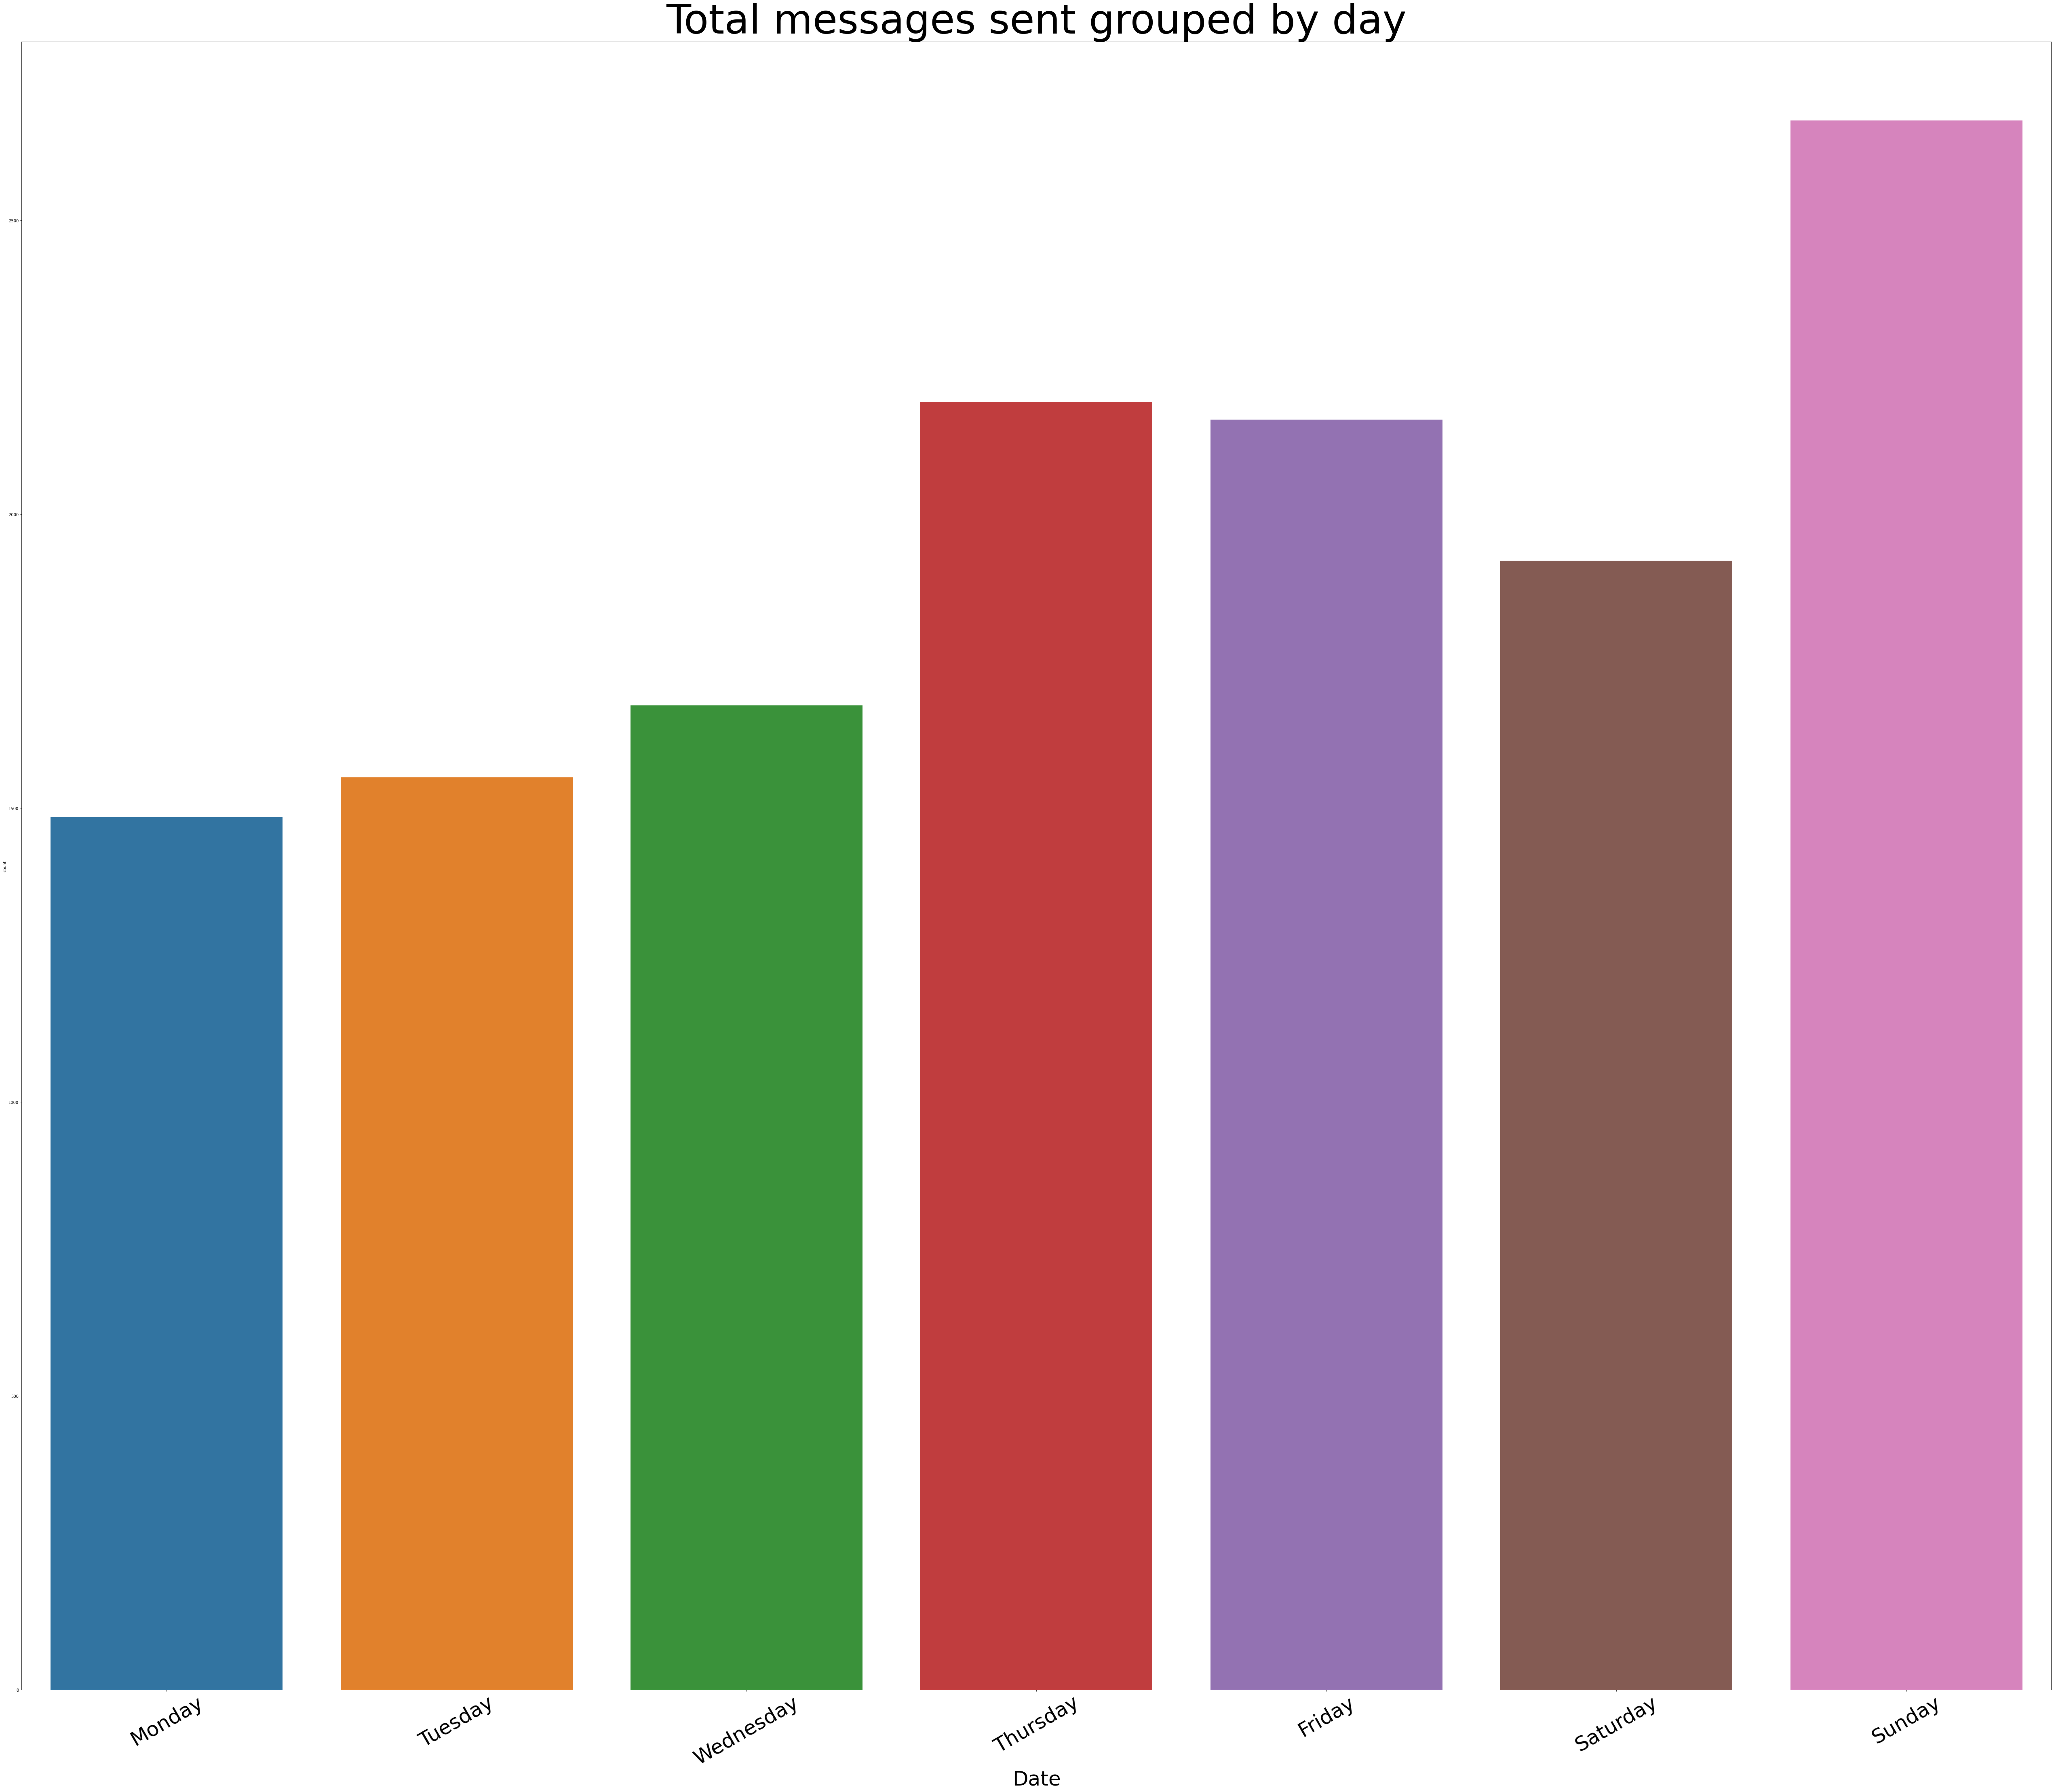

In [7]:
#Total messages sent grouped by day
days = ['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
fig,axs = plt.subplots(figsize = (90,75))
grp_by_day = df.groupby('day').sum().reset_index()[['day','count']]
axs = sns.barplot(y = 'count', x = 'day', data = grp_by_day, order = days)
axs.set_title("Total messages sent grouped by day", fontsize = 100)
axs.set_xticklabels(axs.get_xticklabels(),rotation = 30,fontsize = 50)
axs.set_xlabel("Date",fontsize = 50)
axs.get_figure().savefig("Generated Visuals/Total messages sent grouped by day.png")

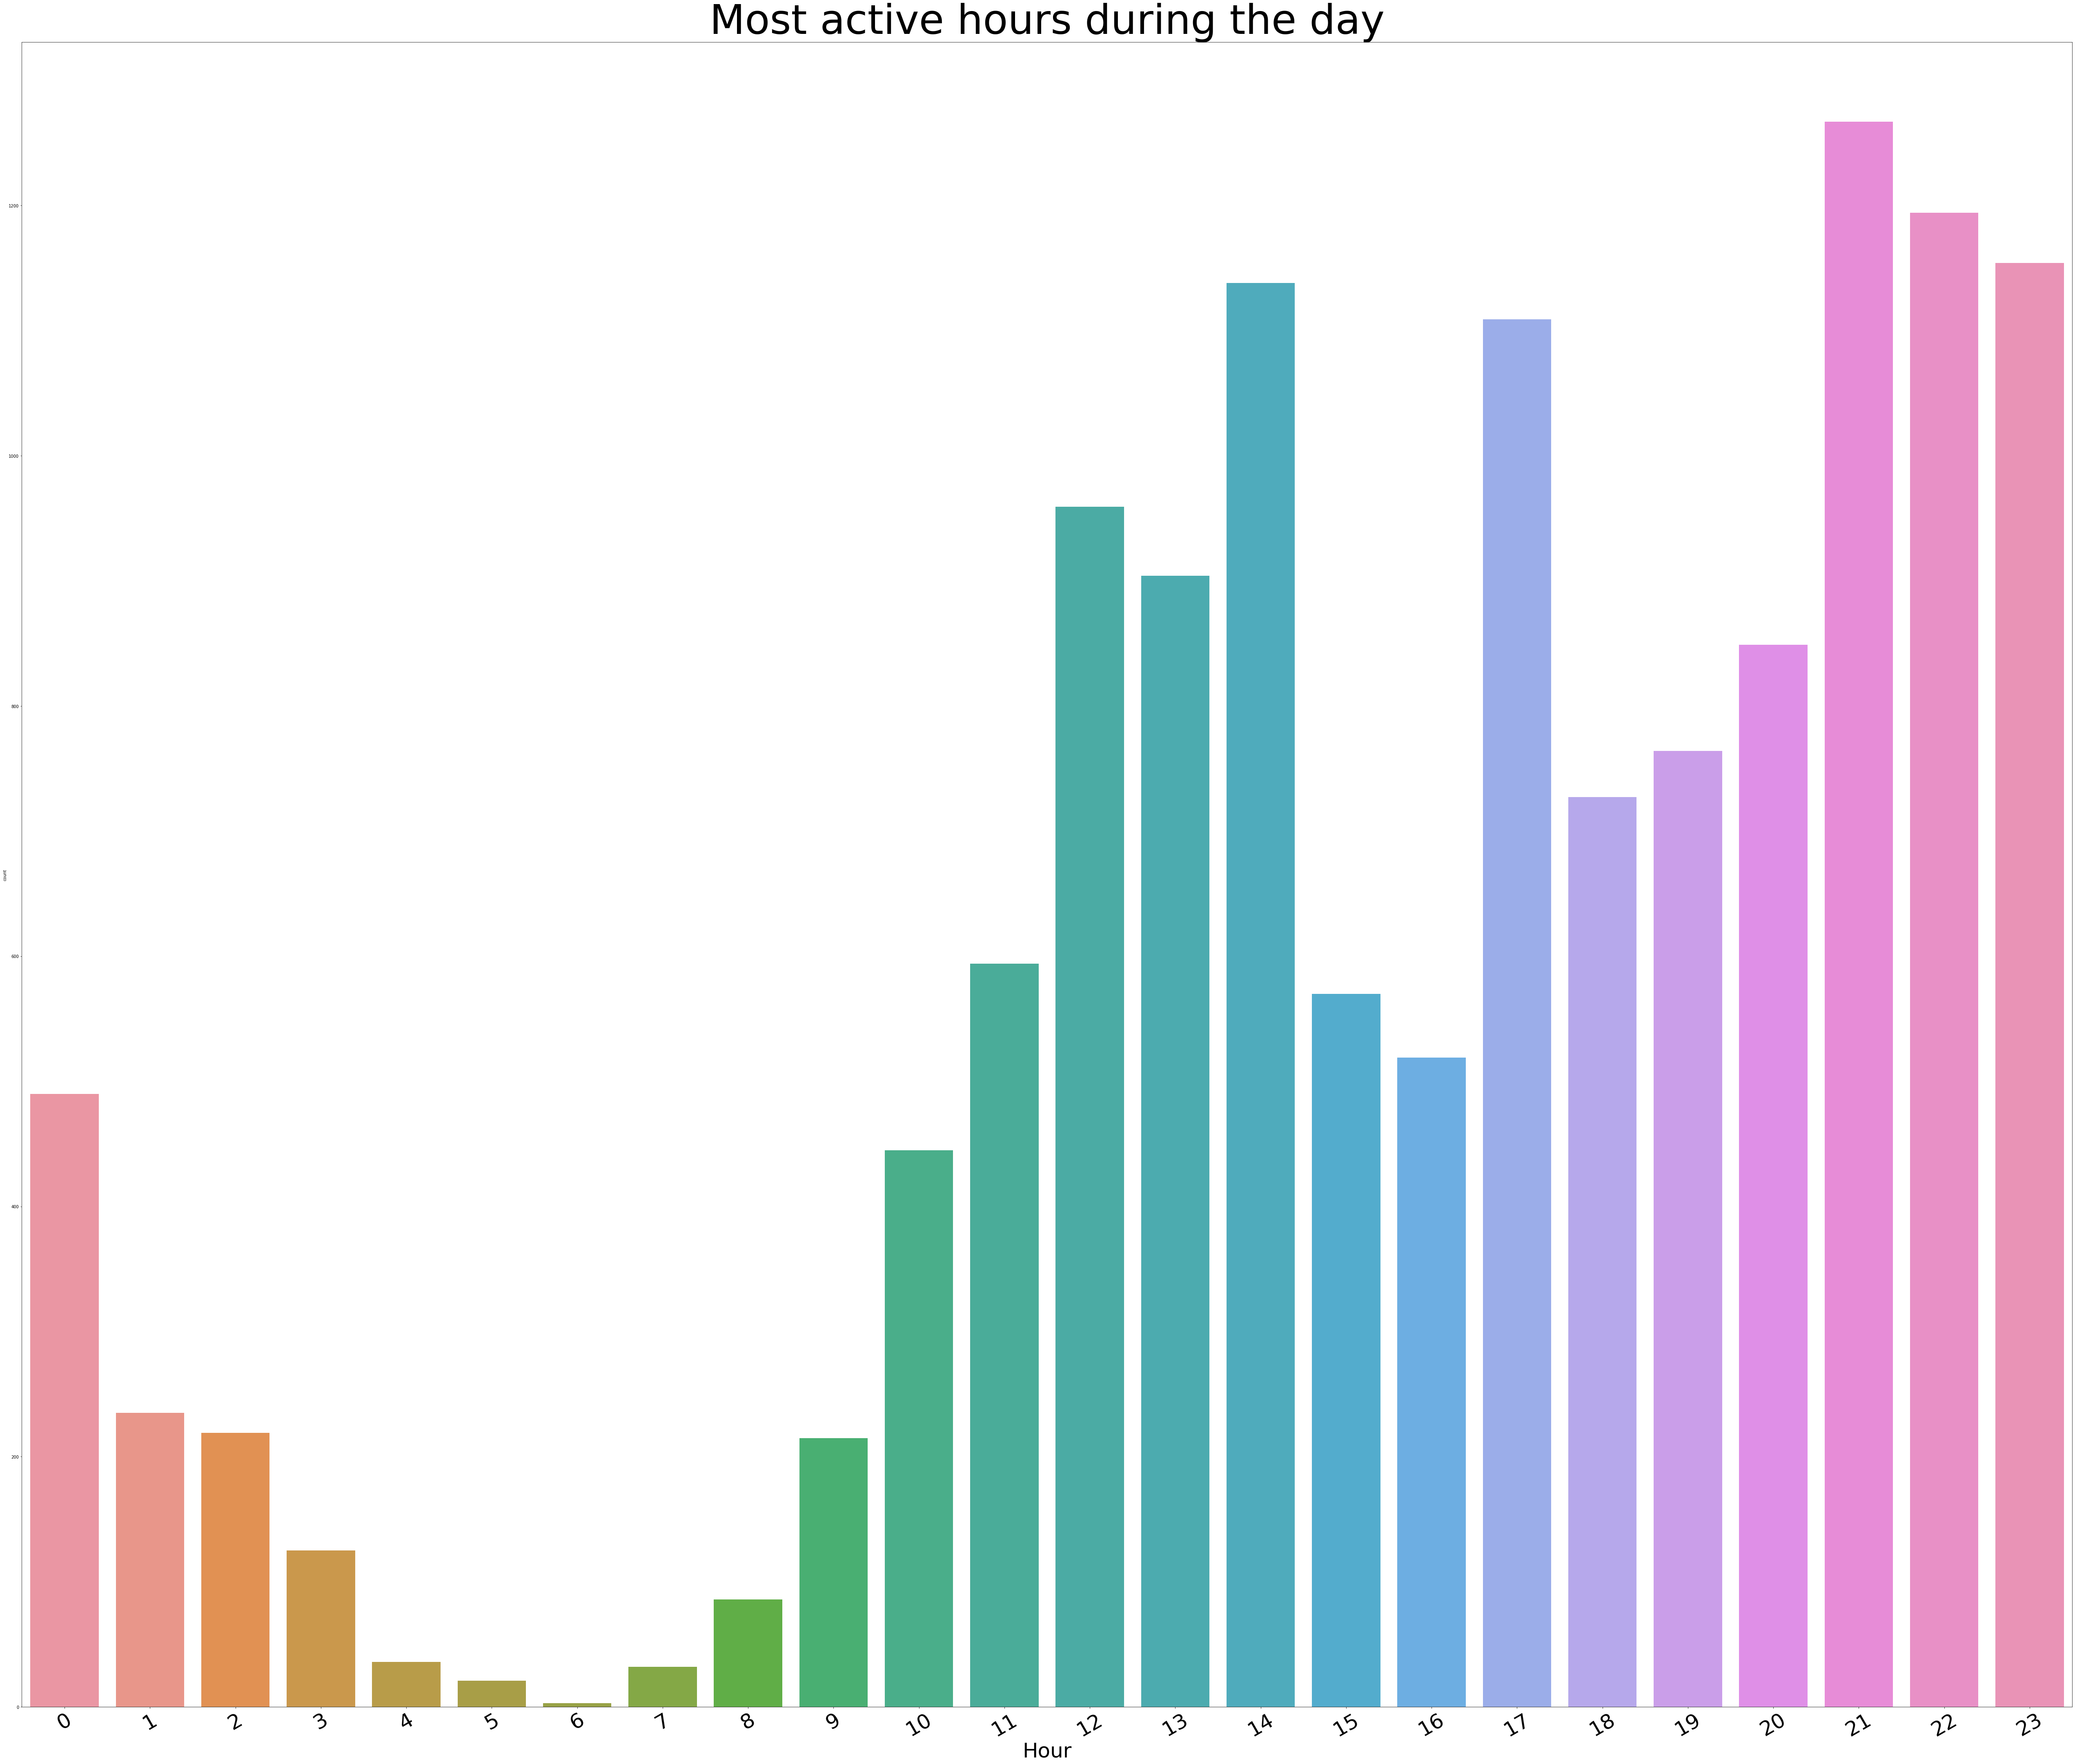

In [8]:
#Most active hours of a day
fig,axs = plt.subplots(figsize = (90,75))
grp_by_hour = df.groupby('hour').sum().reset_index().sort_values(by = 'count', ascending = False)
axs = sns.barplot(y = 'count', x = 'hour', data = grp_by_hour)
axs.set_title("Most active hours during the day", fontsize = 100)
axs.set_xticklabels(axs.get_xticklabels(),rotation = 30,fontsize = 50)
axs.set_xlabel("Hour",fontsize = 50)
axs.get_figure().savefig("Generated Visuals/Most active hours during the day.png")

## Generating time-series graph of messages sent over a period of time

In [15]:
message_count_df = df.copy()
message_count_df = message_count_df.groupby('date_sent').sum().reset_index()
message_count_df['year'] = message_count_df['date_sent'].dt.year
message_count_df

,date_sent,hour,month,count,year
0,2020-01-24,20,1,1,2020
1,2020-01-26,1836,105,105,2020
2,2020-01-27,1856,90,90,2020
3,2020-01-28,1820,126,126,2020
4,2020-01-29,2431,118,118,2020
...,...,...,...,...,...
237,2020-09-28,2360,1296,144,2020
238,2020-09-29,502,441,49,2020
239,2020-09-30,2451,1503,167,2020
240,2020-10-01,695,910,91,2020


C:\Users\Birappa\AppData\Local\Temp\ipykernel_13916\3987218846.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(axs.get_xticklabels(),rotation = 30,fontsize = 50)


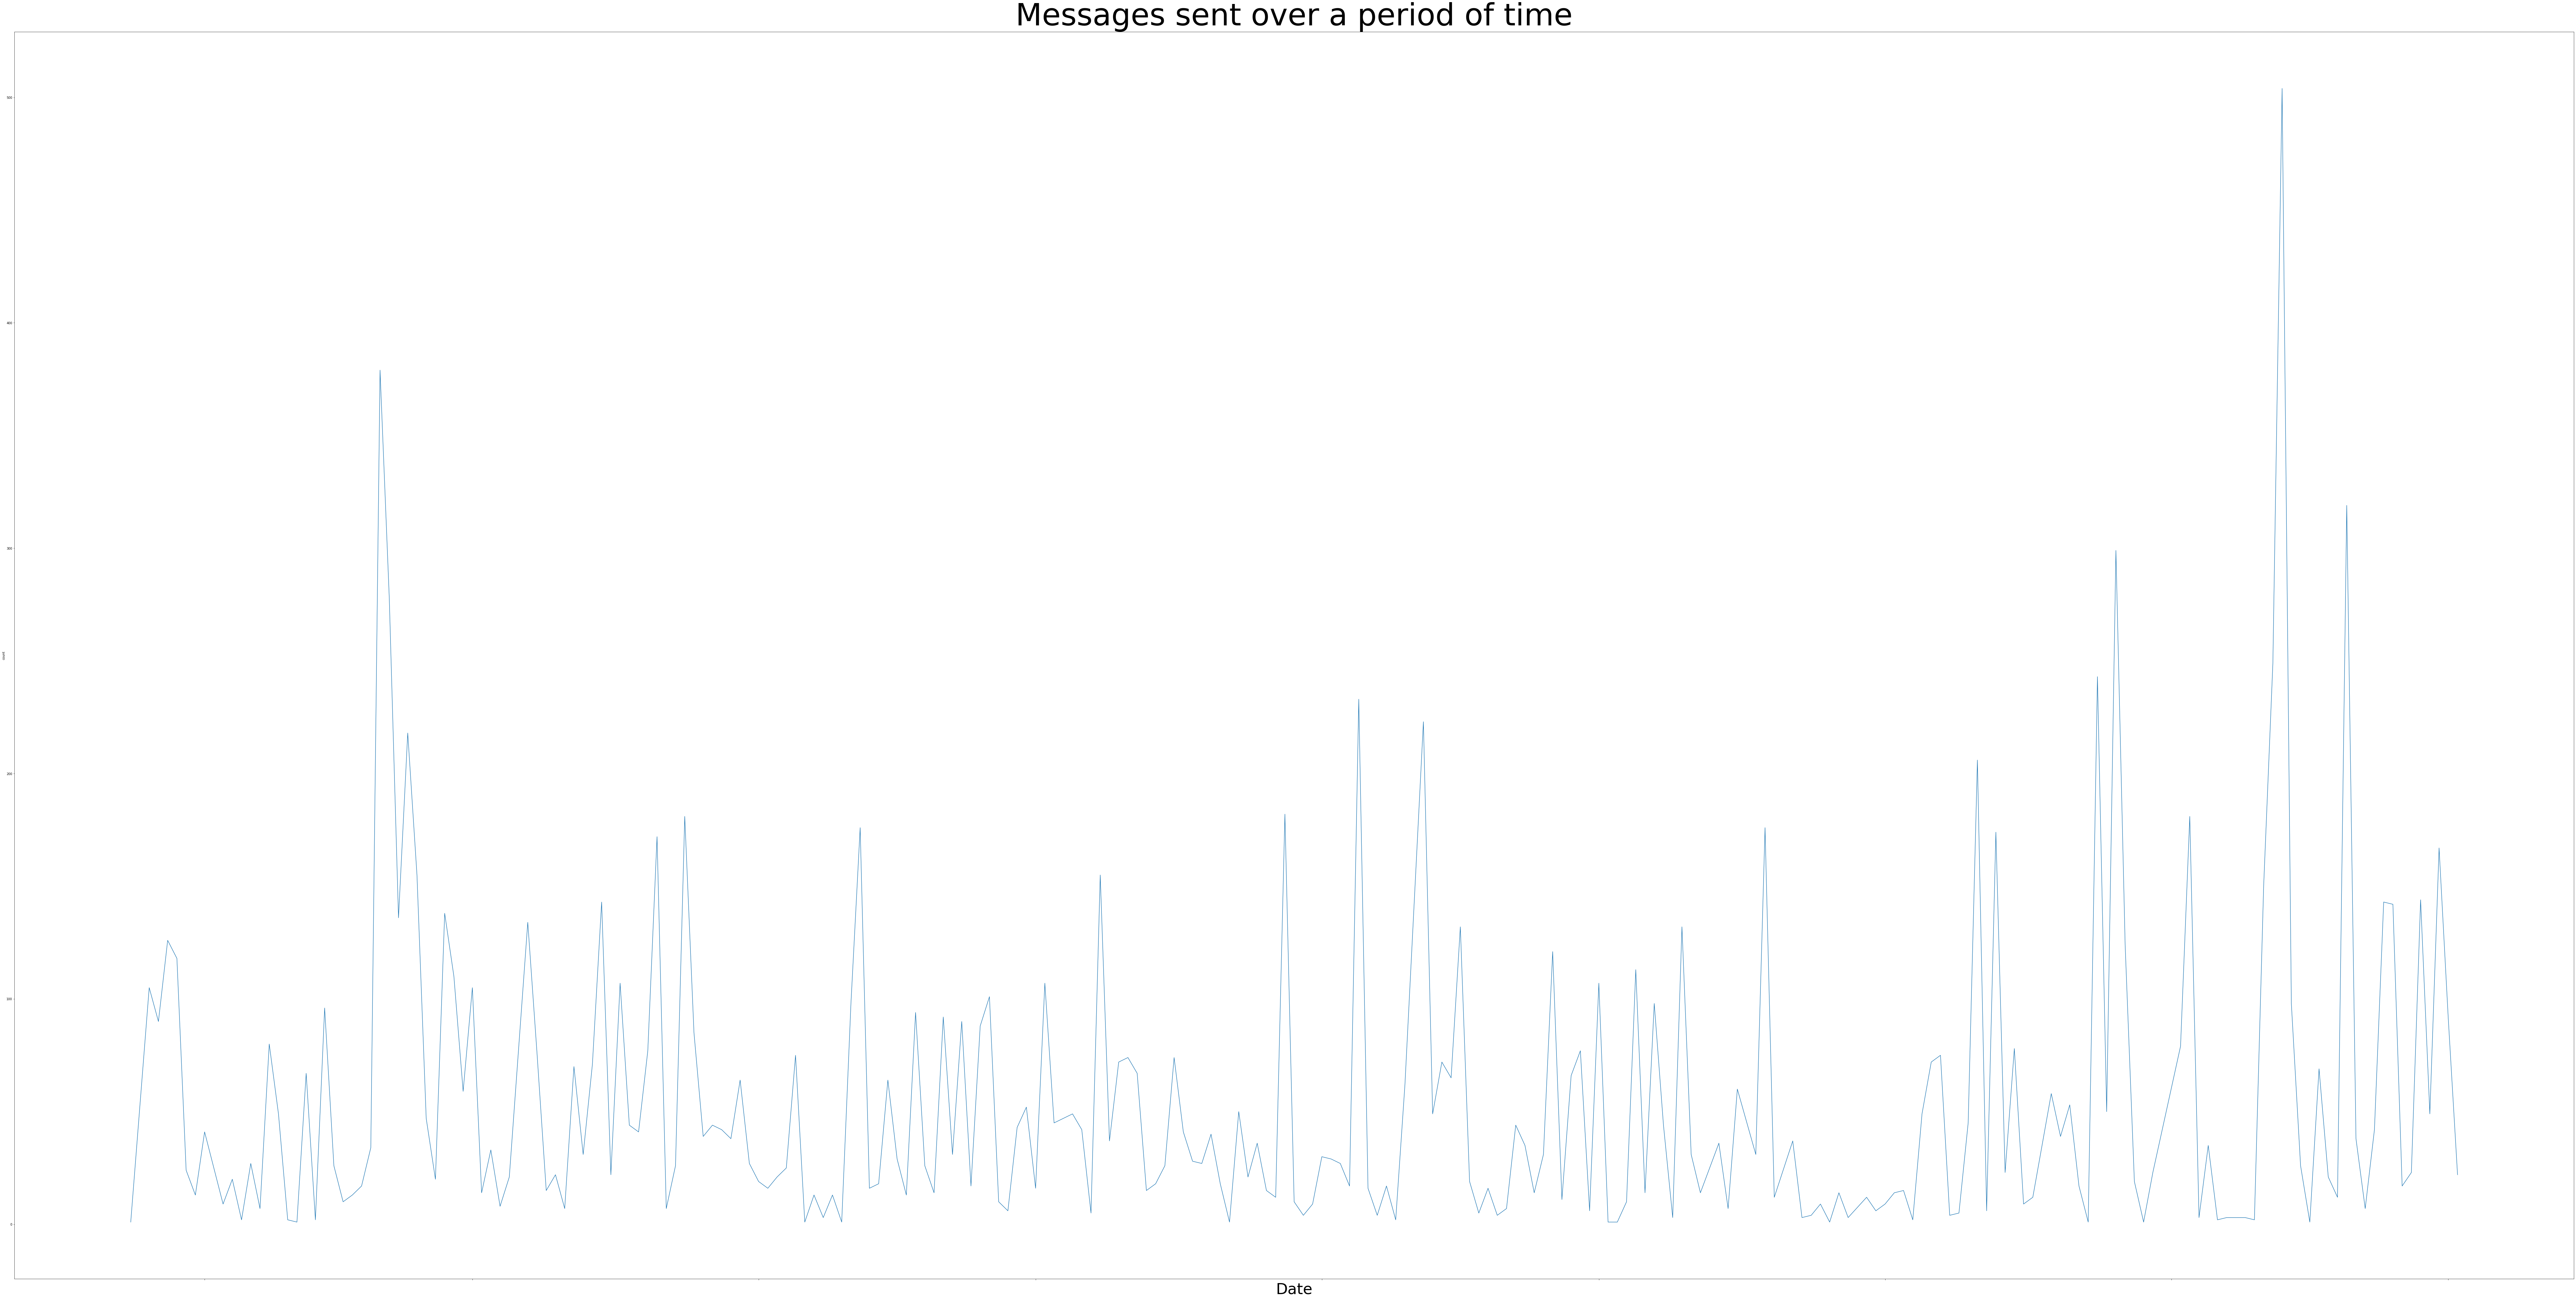

In [16]:
fig,axs = plt.subplots(figsize = (150,75))
axs = sns.lineplot(y = 'count', x = 'date_sent', data = message_count_df)
axs.set_title("Messages sent over a period of time", fontsize = 100)
axs.set_xticklabels(axs.get_xticklabels(),rotation = 30,fontsize = 50)
axs.set_xlabel("Date",fontsize = 50)
axs.get_figure().savefig("Generated Visuals/Messages sent over a period of time.png")